# Setup


In [1]:
# @title connect to drive
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# @title download dataset
!unzip mini_dataset.zip
DATA_DIR = "mini_dataset"


Archive:  mini_dataset.zip
  inflating: mini_dataset/STR/STR_960.png  
  inflating: mini_dataset/TUM/TUM_981.png  
  inflating: mini_dataset/TUM/TUM_95.png  
  inflating: mini_dataset/LYM/LYM_876.png  
  inflating: mini_dataset/DEB/DEB_974.png  
  inflating: mini_dataset/LYM/LYM_8.png  
  inflating: mini_dataset/DEB/DEB_99.png  
  inflating: mini_dataset/NOR/NOR_862.png  
  inflating: mini_dataset/ADI/ADI_985.png  
  inflating: mini_dataset/MUS/MUS_967.png  
  inflating: mini_dataset/MUC/MUC_961.png  
  inflating: mini_dataset/ADI/ADI_899.png  
  inflating: mini_dataset/NOR/NOR_734.png  
  inflating: mini_dataset/MUC/MUC_97.png  
  inflating: mini_dataset/STR/STR_972.png  
  inflating: mini_dataset/MUS/MUS_889.png  


ADI


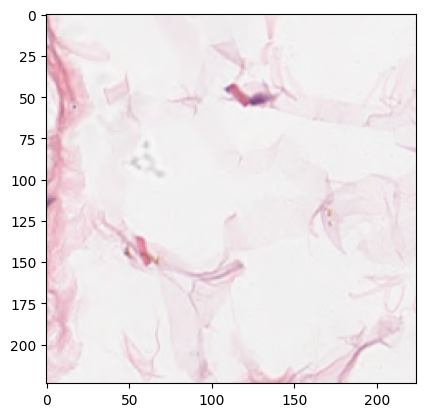

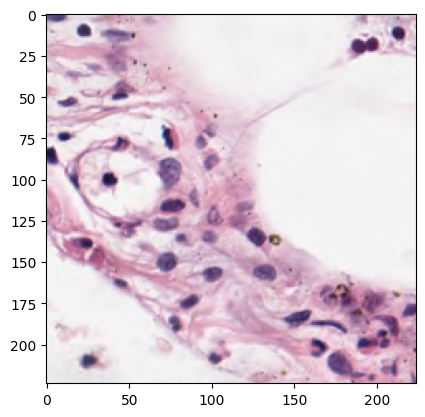

MUC


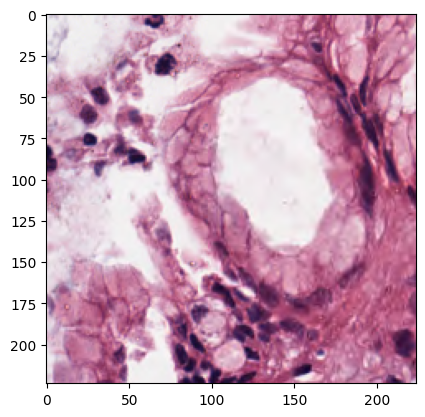

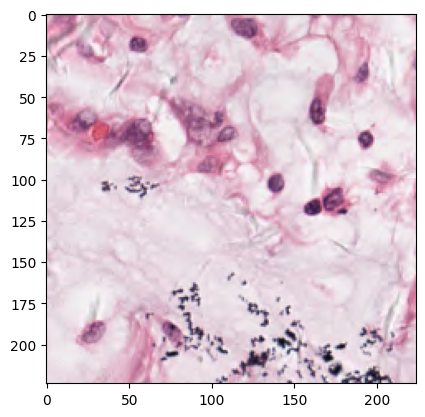

NOR


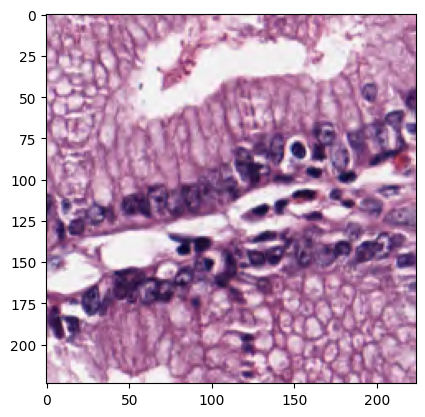

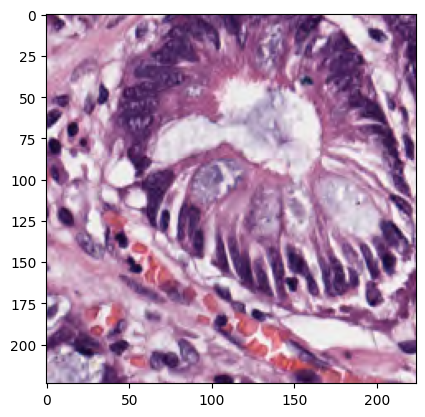

LYM


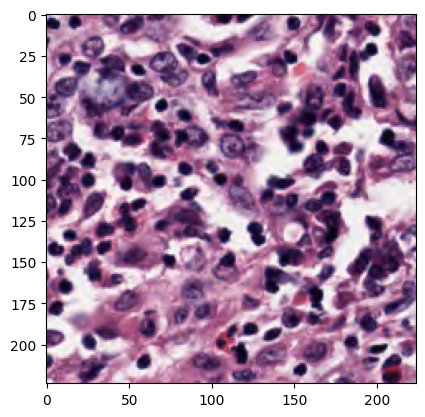

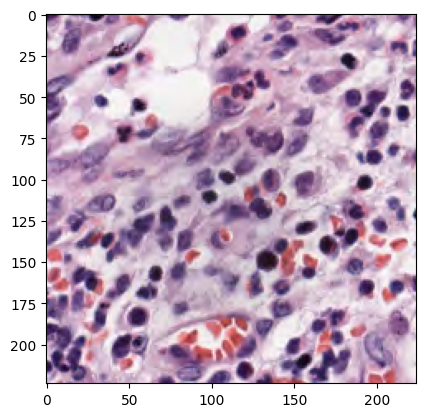

DEB


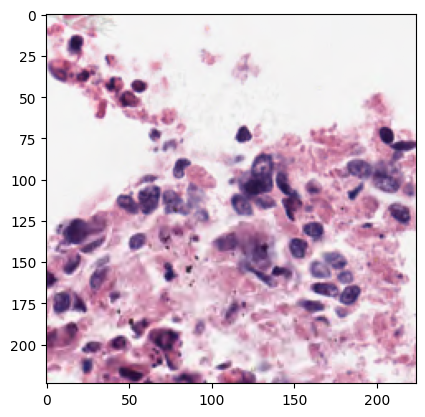

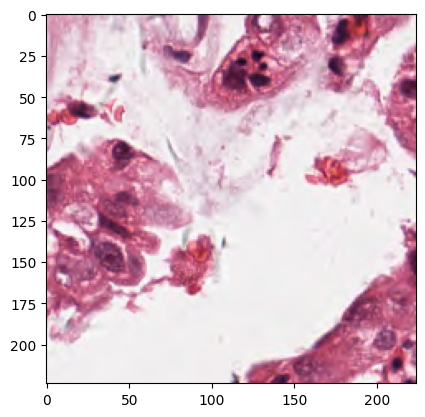

MUS


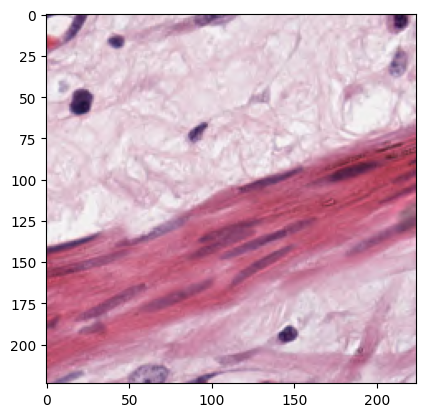

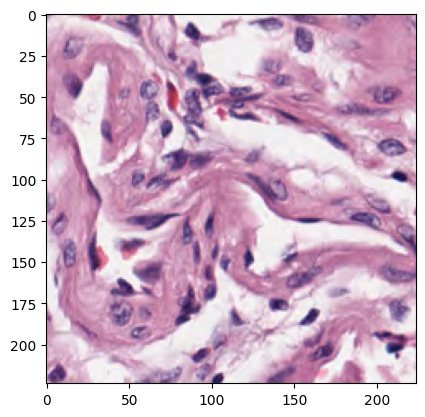

TUM


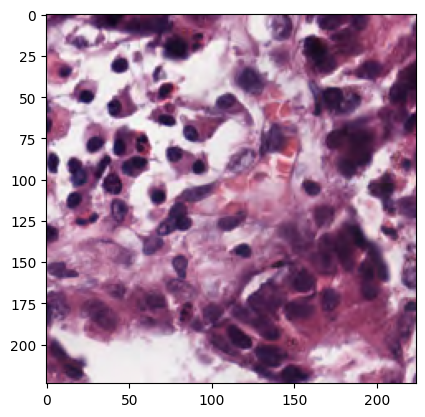

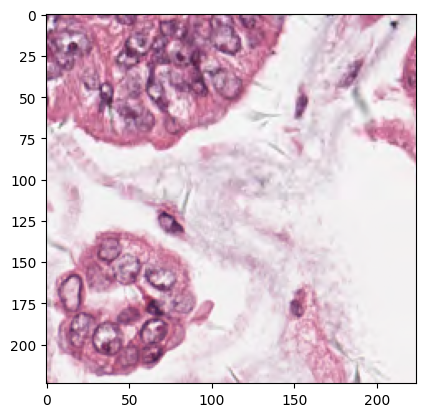

STR


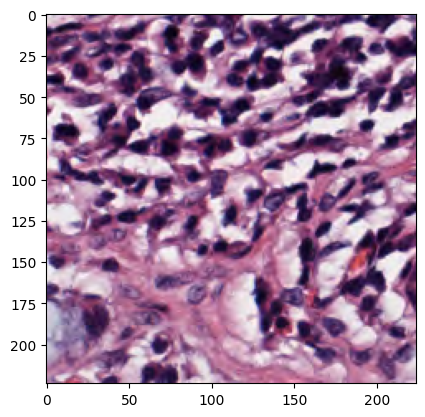

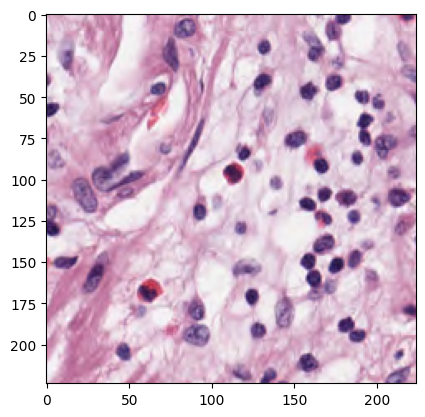

In [3]:
# @title display images
import os
import matplotlib.pyplot as plt
for class_dir in os.listdir(DATA_DIR):
    class_dir_path = os.path.join(DATA_DIR, class_dir)
    print(class_dir)
    for img in os.listdir(class_dir_path):
        img_path = os.path.join(class_dir_path, img)
        if not os.path.isfile(img_path):
            continue
        plt.imshow(plt.imread(img_path))
        plt.show()

In [4]:
# @title install libraries + settings
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
RNG_SEED = 123

!pip install evaluate
!unzip checkpoint-13000.zip


Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Archive:  checkpoint-13000.zip
  inflating: checkpoint-13000/training_args.bin  
  inflating: checkpoint-13000/scheduler.pt  
  inflating: checkpoint-13000/trainer_state.json  
  inflating: checkpoint-13000/rng_state.pth  
  inflating: checkpoint-13000/config.json  
  inflating: checkpoint-13000/model.safetensors  
  inflating: checkpoint-13000/optimizer.pt  


In [5]:
# @title load data
import glob
import pandas as pd
from datasets import load_dataset, DatasetDict


dataset = load_dataset("imagefolder", data_dir=DATA_DIR)



/Users/vidhya/Library/Python/3.11/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
# @title Preprocess Data

from torchvision.transforms import Compose, ToTensor, Resize, Normalize, CenterCrop

_transform_pipeline = Compose([
    Resize(256),
    ToTensor(),
])

def transform_img(batch):
    batch["pixel_values"] = [ _transform_pipeline(img.convert("RGB")) for img in batch["image"]]
    return batch

dataset = dataset.map(
    transform_img,batched=True,batch_size=32,remove_columns=["image"]
)

In [7]:
# @title Collate Function

from transformers import DefaultDataCollator

collator = DefaultDataCollator()

In [10]:
# @title Testing
import torch
from transformers import TrainingArguments, Trainer, EarlyStoppingCallback, AutoModelForImageClassification

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import numpy as np
import evaluate
import numpy as np
import torch

roc_auc_metric = evaluate.load("roc_auc", "multiclass")
accuracy_metric = evaluate.load("accuracy")
precision_metric = evaluate.load("precision")
f1_metric =evaluate.load("f1")
recall_metric =evaluate.load("recall")

def compute_metrics(eval_pred):
    logits, labels = eval_pred

    probs = torch.softmax(torch.tensor(logits, dtype=torch.float32), dim=1).numpy()
    labels = labels.astype(np.int32)
    predictions = np.argmax(logits, axis=-1)

    results = {}

    results["roc_auc"] = roc_auc_metric.compute(
        references=labels,
        prediction_scores=probs,
        multi_class="ovr",
    )["roc_auc"]

    results["accuracy"] = accuracy_metric.compute(
        predictions=predictions,
        references=labels,
    )["accuracy"]

    results["precision"] = precision_metric.compute(
        predictions=predictions,
        references=labels,
        average="macro",
    )["precision"]

    results["f1"] = f1_metric.compute(
        predictions=predictions,
        references=labels,
        average="macro",
    )["f1"]

    results["recall"] = recall_metric.compute(
        predictions=predictions,
        references=labels,
        average="macro",
    )["recall"]

    return results


checkpoint_path = "./checkpoint-13000"

model = AutoModelForImageClassification.from_pretrained(
    checkpoint_path,
    use_safetensors=True
)

training_args = TrainingArguments(
    eval_strategy = "steps",
    save_strategy = "steps",
    learning_rate = 1e-4,
    weight_decay = 1e-4,
    num_train_epochs = 10,
    save_steps=500,
    eval_steps=500,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    logging_steps = 500,
    report_to = "tensorboard",
    save_total_limit=3,
    remove_unused_columns=False
    )

trainer = Trainer(
    model=model,
    data_collator = collator,
    train_dataset=dataset,
    args=training_args,
    eval_dataset=dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=5)],
)


test_results = trainer.evaluate(dataset)
print(test_results)

pd.DataFrame(list(test_results.items()), columns=["Metric", "Value"])





/Users/vidhya/Library/Python/3.11/lib/python/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


/Users/vidhya/Library/Python/3.11/lib/python/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
early stopping required metric_for_best_model, but did not find eval_loss so early stopping is disabled


{'eval_train_loss': 0.8428382873535156, 'eval_train_model_preparation_time': 0.0024, 'eval_train_roc_auc': 0.9598214285714286, 'eval_train_accuracy': 0.625, 'eval_train_precision': 0.6541666666666666, 'eval_train_f1': 0.5839285714285714, 'eval_train_recall': 0.625, 'eval_train_runtime': 6.4443, 'eval_train_samples_per_second': 2.483, 'eval_train_steps_per_second': 0.31}


Metric     Value
0                    eval_train_loss  0.842838
1  eval_train_model_preparation_time  0.002400
2                 eval_train_roc_auc  0.959821
3                eval_train_accuracy  0.625000
4               eval_train_precision  0.654167
5                      eval_train_f1  0.583929
6                  eval_train_recall  0.625000
7                 eval_train_runtime  6.444300
8      eval_train_samples_per_second  2.483000
9        eval_train_steps_per_second  0.310000